In [1]:
%reload_ext autoreload
%autoreload 2

In [1]:
from dataset.dialogue_graph_datamodule import SubDialogueDataModule
import torch 
from tqdm import tqdm
from model import GiBERTino

model = GiBERTino.load_from_checkpoint("./giBERTino-alibaba-GCN-STAC-epoch=28-val_loss=0.14.ckpt")

model.eval()
data_module = SubDialogueDataModule("data/STAC/alibaba-graphs", num_workers=0)
data_module.setup(stage="test")
test_loader = data_module.test_dataloader()

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Processing test data"):
        link_logits, rel_probs = model(batch)

        link_labels = batch[('edu', 'to', 'edu')].get('link_labels', None)
        rel_labels = batch[('edu', 'to', 'edu')].get('rel_labels', None)
        break

2025-05-29 08:42:03,856 - INFO - Use pytorch device_name: mps
2025-05-29 08:42:03,856 - INFO - Load pretrained SentenceTransformer: Alibaba-NLP/gte-modernbert-base
Processing test data:   0%|          | 0/5 [00:01<?, ?it/s]


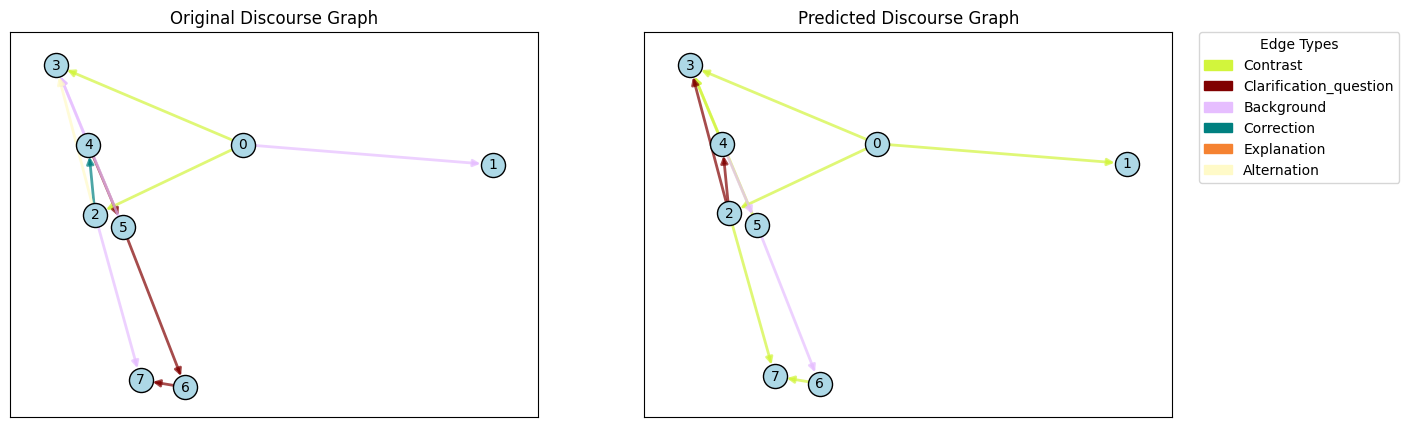

In [4]:
from utils.constants import RELATIONS
from utils import create_graph_from_predictions

idx = 31

edge_index = batch.to_data_list()[idx]["edu", "to", "edu"].edge_index.T
link_labels = batch.to_data_list()[idx]["edu", "to", "edu"].link_labels
rel_labels = batch.to_data_list()[idx]["edu", "to", "edu"].rel_labels

g = batch.to_data_list()[idx]
preds = link_logits[:g["edu", "to", "edu"].link_labels.shape[0]]
rel_preds = rel_probs[:g["edu", "to", "edu"].rel_labels.shape[0]]
relations = RELATIONS["UNIFIED"]

graph = create_graph_from_predictions(g, relations, preds, rel_preds)

In [5]:
import networkx as nx
from torch_geometric.utils import to_networkx

from utils import create_gif_from_graphs

new_graph = to_networkx(graph, to_undirected=False)

all_paths = []

for src in new_graph.nodes:
    for dst in new_graph.nodes:
        if src != dst:
            paths = list(nx.all_simple_paths(new_graph, source=src, target=dst))
            all_paths.extend(paths)
            
create_gif_from_graphs(g, graph, all_paths)

GIF successfully created: graph_evolution.gif


'graph_evolution.gif'